In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import glob

from jupyterthemes import jtplot
from ali.ali_sw import *
from ali.ali_peaks import *
from ali.recovery_times import *

In [5]:
jtplot.style('default', grid=False)

In [6]:
plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 14)
plt.rc('xtick', labelsize= 14)
plt.rc('xtick.major', size=4)
plt.rc('ytick.major', size=4)

# Process peaks 

In [ ]:
path = '../../ali_data/Ba(ClO4)2_shooting/*'
files = glob.glob(path)
files, len(files)

In [5]:
for f in files[:-1]:
    dfp = process_dfRaw_peaks(path = f, )
    save_processed_peaks(f, dfp)

Saving processed peaks df to  ../../ali_data/Ba(ClO4)2_shooting/processed_peaks/24112019_baclo42_FBI_silica_26mg_50ms_1000mbar_3000pulses.pyk
Saving processed peaks df to  ../../ali_data/Ba(ClO4)2_shooting/processed_peaks/24112019_baclo42_FBI_silica_26mg_50ms_200mbar_1000pulses.pyk
Saving processed peaks df to  ../../ali_data/Ba(ClO4)2_shooting/processed_peaks/23112019_baclo42_FBI_silica_36mg_50ms_800mbar_300pulses.pyk


# Load processed peaks

In [7]:
path = '../../ali_data/Ba(ClO4)2_shooting/processed_peaks/*'
files = glob.glob(path)
files, len(files)

(['../../ali_data/Ba(ClO4)2_shooting/processed_peaks/24112019_baclo42_FBI_silica_26mg_50ms_200mbar_1000pulses.pyk',
  '../../ali_data/Ba(ClO4)2_shooting/processed_peaks/23112019_baclo42_FBI_silica_36mg_50ms_800mbar_300pulses.pyk',
  '../../ali_data/Ba(ClO4)2_shooting/processed_peaks/24112019_baclo42_FBI_silica_26mg_50ms_1000mbar_3000pulses.pyk'],
 3)

# Run 1: 300 pulses

In [8]:
exp300 = import_peaks(files[1])
dfp = exp300.dfp

Text(0.5, 1.0, 'Ba(ClO4)2 onto FBI Silica, 305 pulses')

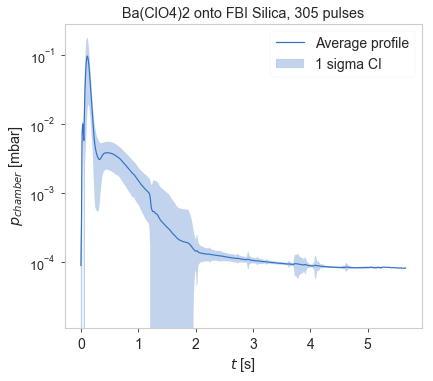

In [9]:
Npeaks = len(dfp.columns)
plotAverageProfile(dfp, nsigma = 1, lb='Average profile', lb2='1 sigma CI')
plt.title('Ba(ClO4)2 onto FBI Silica, {} pulses'.format(Npeaks))

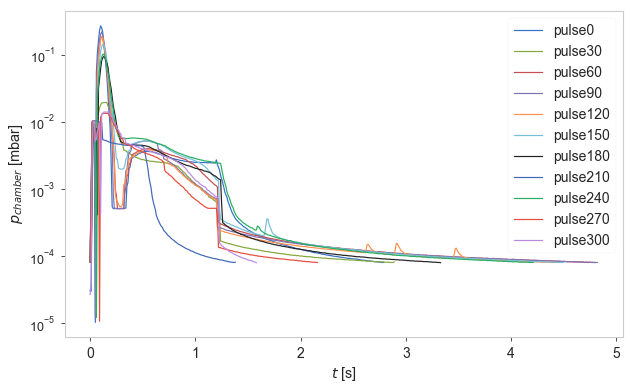

In [10]:
plt.figure(figsize=(10,6))
overplot_every_N_pulses(dfp, every=30)

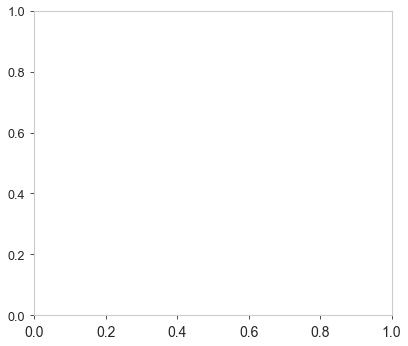

In [32]:
def plotRecoveryTimes(dfp : pd.DataFrame, pAct : float , ax : plt.axes = plt.gca(),
                     col : str = 'b', lb : str = '') -> list:
    """Compute and plot recovery times from a dfpPeak and specified pAct
    Return recovery time
    Input:
    dfp : pd.DataFrame
        ALI peaks df (from .pyk file)
    pAct : float
        pressure threshold for recovery time
    """
    rT = []
    Npeaks = len(dfp.columns)
    for i in dfp.columns:
        rPt = findRecoveryPoints(dfp[i], pAct)
        if len(rPt) > 0:
            rT.append(rPt[0]/100)
    if ax == None:
        ax = plt.gca()
    ax.plot(rT, 'o', color=col, label=lb)
    ax.set_xlabel('pulse nr.')
    ax.set_ylabel('recovery time [s]')
    return rT

def plot_maxP(dfp : pd.DataFrame, ax : plt.axes = plt.gca(), col = 'b', lb : str = '') -> list:
    """Compute and plot max reached pressures in a dfPeak
    Return list of maxP
    Input:
    dfp : pd.DataFrame
        ALI peaks df (from .pyk file)
    Output:
    maxP : list
        List of max. pressures reached per peak"""

    maxP = dfp.max(axis=0).values
    ax.semilogy(maxP, 'o', color = col, label=lb)
    ax.set_xlabel('pulse nr.')
    ax.set_ylabel('$p_{max}$ [mbar]')
    return maxP

Text(0.5, 1.0, 'Recovery times')

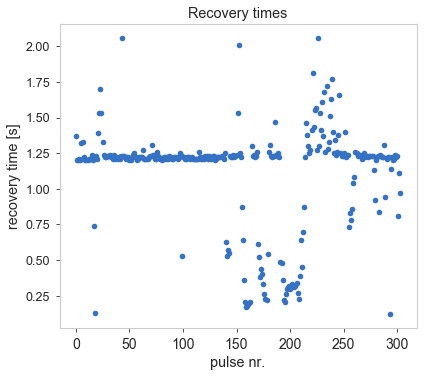

In [40]:
rT = plotRecoveryTimes(dfp, pAct=4e-4, ax = plt.gca());
plt.title('Recovery times')

Text(0.5, 1.0, 'Peak pressure')

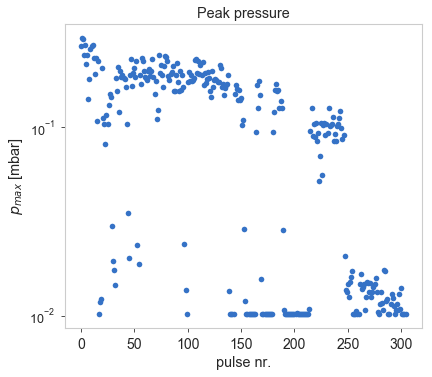

In [41]:
maxP = plot_maxP(dfp, ax = plt.gca());
plt.title('Peak pressure')

Text(0.5, 1.0, 'Correlation $t_{recov}$ : $p_{max}$')

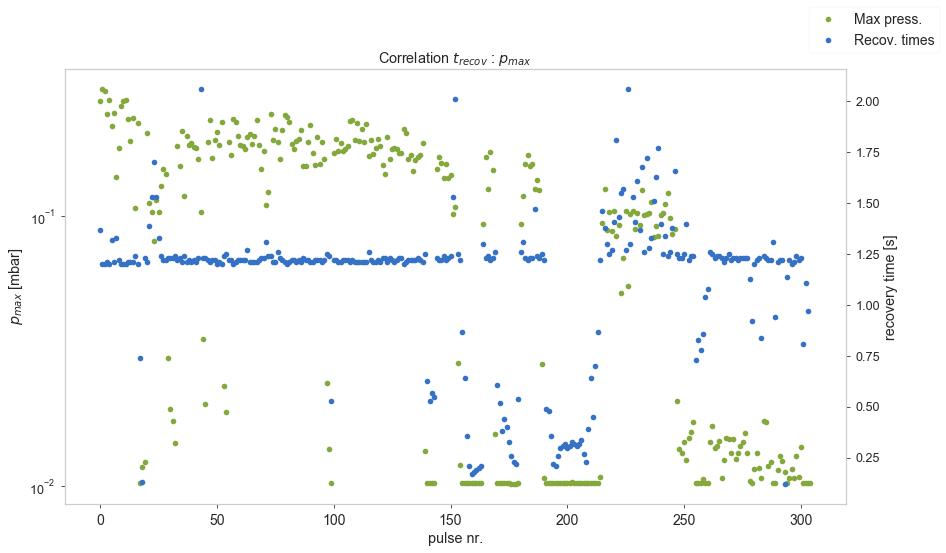

In [42]:
fig = plt.figure(figsize=(14, 8))
ax = plt.gca()
maxP = plot_maxP(dfp, ax = ax, col='g', lb='Max press.')
ax2 = plt.twinx(ax)
rT = plotRecoveryTimes(dfp, pAct=4e-4, ax = ax2, lb='Recov. times')
plt.gcf().legend()
plt.title('Correlation $t_{recov}$ : $p_{max}$')

## Select only "wet" peaks

In [63]:
def split_wet_dry(dfp : pd.DataFrame, nsigma : float = 1., DEBUG : bool = False)->tuple:
    """
        Split run by chi2 soft thresholding
        Input:
        ------
        dfp : pulse df to split
        nsigma : nr of std deviations over/below average to set chi2 threshold
            if negative reverse dry <-> wet
        Output:
        -------
        dryPulses : dfp with lower p_max (bkg)
        wetPulses : dfp with higher p_max
    """
    maxP = plot_maxP(dfp)
    x = np.arange(len(maxP))
    UmaxP = 0.3 * np.array(maxP)         # Systematic error of press gauge
        
    from scipy.optimize import curve_fit
    def const (x, a): return a          # fit to constant value to extract chi2

    fit, cov = curve_fit(const,x, maxP)
    assert fit[0] > np.min(maxP) and fit[0] < np.max(maxP), "av maxP out of bounds"
    
    chi2 = (maxP - fit[0])**2/UmaxP**2
    sd = np.std(chi2)
    avg = np.average(chi2)
    
    if DEBUG:
        plt.axhline(y=avg, color='r')
        plt.plot(x, chi2, '.')
        plt.fill_between(x, avg - nsigma*sd, avg + nsigma*sd, color='r', alpha=0.3)
        plt.title('Max pressure per pulse')
    
    wetId = np.where(chi2 < avg + nsigma * sd)[0]
    dryId = np.where(chi2 >= avg + nsigma * sd)[0]
    
    wetPulses = pd.concat((dfp.iloc[:,p] for p in wetId), axis=1)
    dryPulses = pd.concat((dfp.iloc[:,p] for p in dryId), axis=1)
    return wetPulses, dryPulses

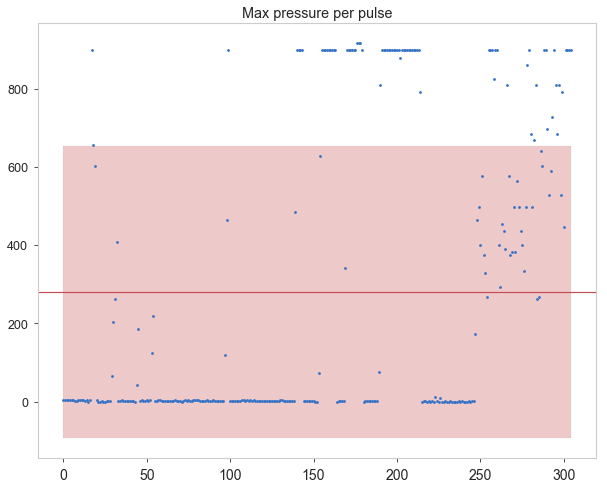

In [88]:
plt.figure(figsize=(10,8))
wetP, dryP = split_wet_dry(dfp, DEBUG=True)

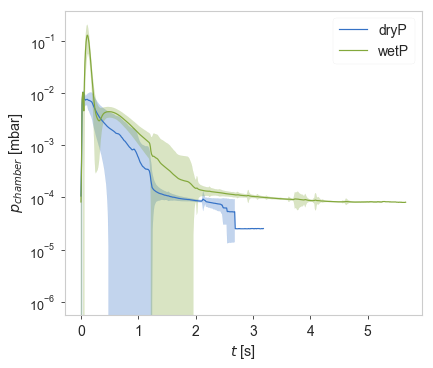

In [97]:
plotAverageProfile(dryP, lb='dryP')

plotAverageProfile(wetP, lb='wetP')

### Filter wet/dry by $p_{max}^{thres} = \overline{p_{max}} + \delta p_{max}$ 

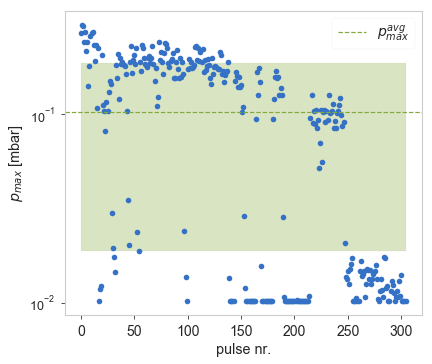

In [74]:
maxP = plot_maxP(dfp, ax = plt.gca());

x = np.arange(len(maxP))
avg = np.average(maxP)
sd = np.std(maxP)
plt.axhline(avg, c='g', ls='--', label='$p_{max}^{avg}$')
plt.fill_between(x, avg-sd, avg+sd, color='g', alpha=0.3)

plt.legend()

In [183]:
wetId2

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,
        46,  47,  48,  49,  50,  51,  52,  53,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 162, 163,
       164, 165, 166, 167, 168, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 23

In [168]:
wetId

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 162, 163, 164, 165, 166, 167, 168,
       169, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 215,
       216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 22

In [184]:
len(wetId2), len(wetId)

(191, 232)

No handles with labels found to put in legend.


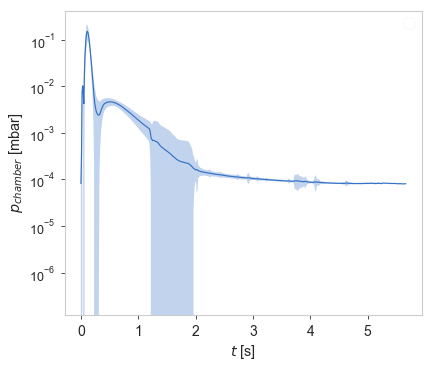

In [75]:
wetId2 = np.where(maxP > avg - sd)[0]

wetPeaks2 = pd.concat((dfp.iloc[:,p] for p in wetId2), axis=1)
plotAverageProfile(wetPeaks2)

No handles with labels found to put in legend.


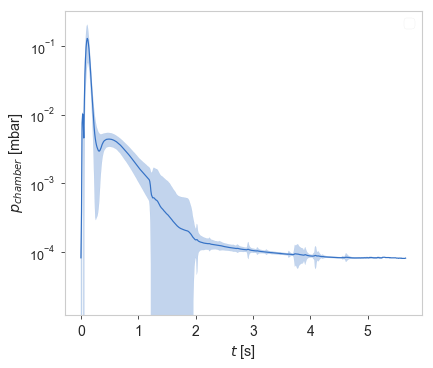

In [76]:
wetId = np.where(chi2 < np.average(chi2) + np.std(chi2))[0]
x = dfp.index.values/100
# av_p = np.array(dfp.mean(axis=1))
# sd_p = np.array(dfp.std(axis=1))
wetPeaks = pd.concat((dfp.iloc[:,p] for p in wetId), axis=1)
plotAverageProfile(wetPeaks)

No handles with labels found to put in legend.


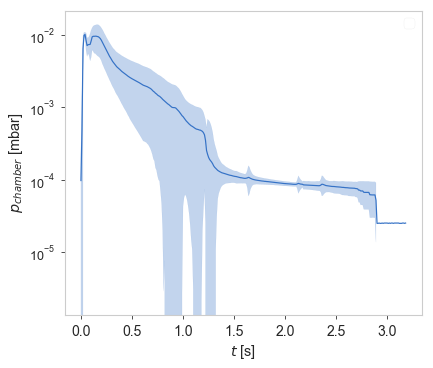

In [77]:
dryId2 = np.where(maxP < avg - sd)[0]

x = dfp.index.values/100
# av_p = np.array(dfp.mean(axis=1))
# sd_p = np.array(dfp.std(axis=1))
dryPeaks = pd.concat((dfp.iloc[:,p] for p in dryId2), axis=1)
plotAverageProfile(dryPeaks)

No handles with labels found to put in legend.


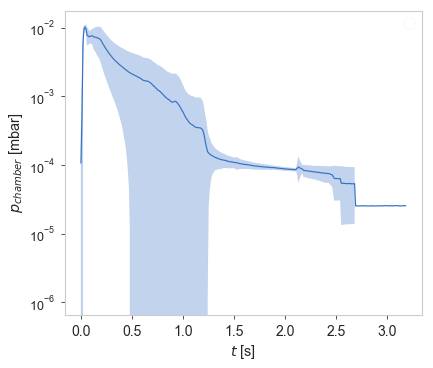

In [78]:
dryId = np.where(chi2 > np.average(chi2) + np.std(chi2))[0]
x = dfp.index.values/100
# av_p = np.array(dfp.mean(axis=1))
# sd_p = np.array(dfp.std(axis=1))
dryPeaks = pd.concat((dfp.iloc[:,p] for p in dryId), axis=1)
plotAverageProfile(dryPeaks)

## Crop pulse until average recTime:

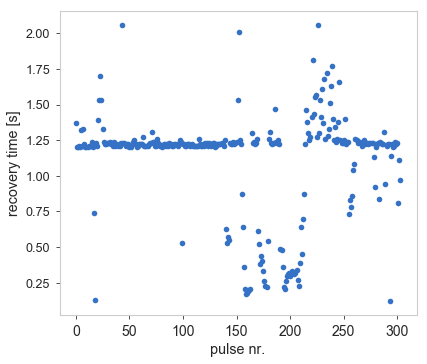

In [40]:
rT = plotRecoveryTimes(dfp, pAct=4e-4, ax = plt.gca());


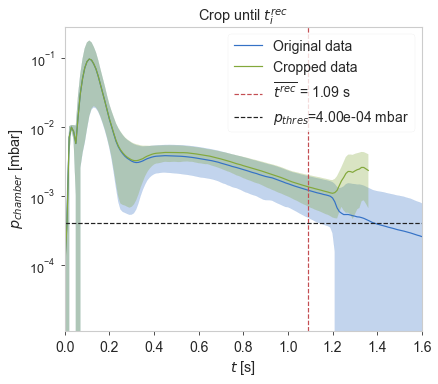

In [511]:
dfshort = shorten_dfp(dfp, pThres=4e-4)
plotAverageProfile(dfp, lb='Original data')
plotAverageProfile(dfshort, lb='Cropped data')
plt.title('Crop until $t^{rec}_i$')
plt.axvline(np.average(rT), ls='--', color='r',
            label='$\overline{t^{rec}}$ = %.2f s' %np.average(rT))
plt.axhline(4e-4, c='k', ls='--', label='$p_{thres}$=%.2e mbar'%4e-4)
plt.xlim(0, 1.6)
plt.legend(loc='upper right')

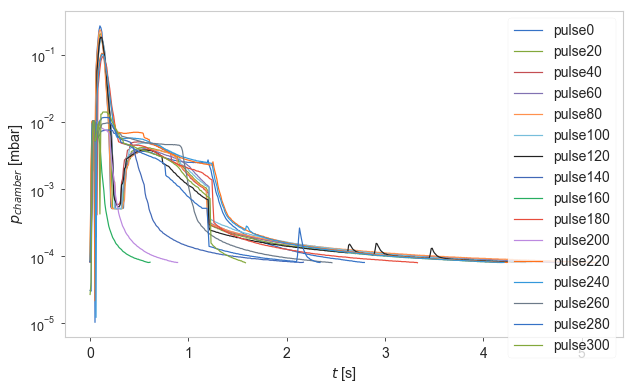

In [84]:
plt.figure(figsize=(10,6))
overplot_every_N_pulses(dfp, every=20)

In [90]:
np.average(rT), np.std(rT)

(1.1455474452554744, 0.31558177005074894)

## Split dry/wet until $t_{rec}$

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Dry pulses')

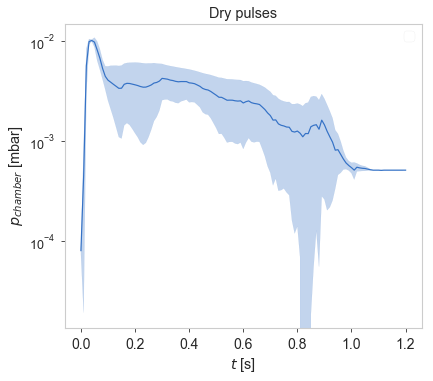

In [512]:
plotAverageProfile(dryPs)
plt.title('Dry pulses')

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Wet pulses')

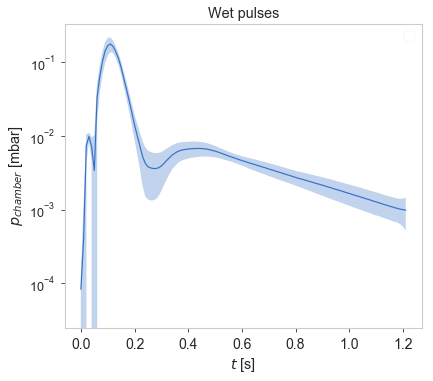

In [513]:
plotAverageProfile(wetPs)
plt.title('Wet pulses')

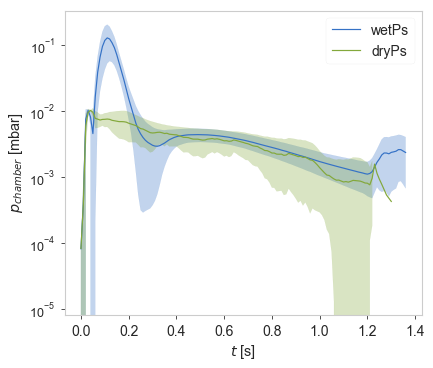

In [514]:
wetPs, dryPs = split_wet_dry(dfshort)
plotAverageProfile(wetPs, lb='wetPs')
plotAverageProfile(dryPs, lb='dryPs')

(0, 1.4)

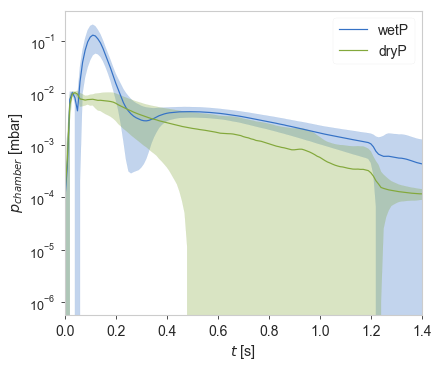

In [92]:
plotAverageProfile(wetP, lb='wetP')
plotAverageProfile(dryP, lb='dryP')
plt.xlim(0,1.4)

## Plot area distribution by pulse

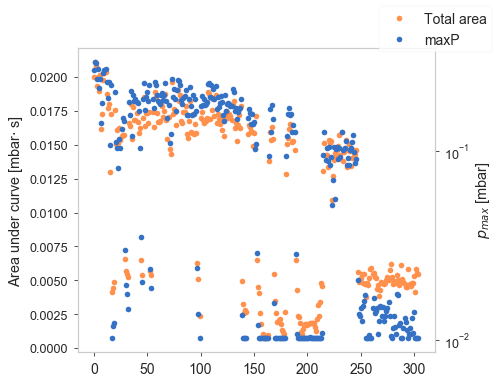

In [150]:
areas = [np.trapz(dfp[pul].dropna(), x=dfp[pul].dropna().index/100) for pul in dfp]
ax = plt.gca()
ax.plot(areas, 'o', color='y', label='Total area')
ax.set_ylabel('Area under curve [mbar$\cdot$ s]')
ax2 = plt.twinx(ax)

plot_maxP(dfp, ax=ax2, flag_p=True, lb='maxP');
plt.gcf().legend(loc='upper right')

### Integrate until argmax

Text(0.5, 1.0, 'Area under pulse during pressure raise')

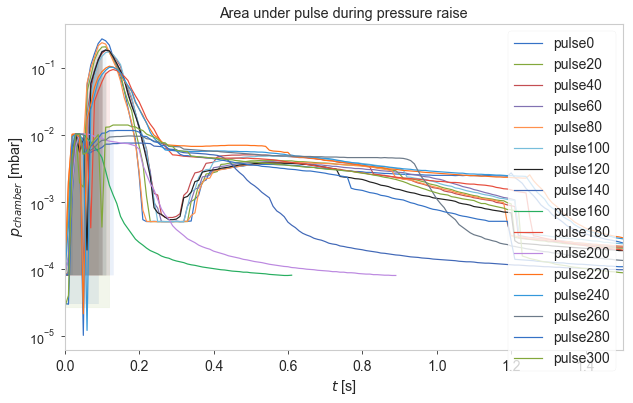

In [140]:
every = 20
Npeaks = len(dfp.columns)
x = dfp.index.values/100
plt.figure(figsize=(10, 6))
ax = plt.gca()
for i in dfp.iloc[:, ::every]:
    col = ax.plot(x, dfp[i], label=i)[0].get_color()
    mxp = np.argmax(dfp[i])
    ax.fill_between(x[:mxp], y1=dfp[i].iloc[0], y2=dfp[i].iloc[:mxp], color=col, alpha=0.1)
ax.set_xlim(0, 1.5)
cosmetics_aliplot()
ax.set_title('Area under pulse during pressure raise')

Text(0.5, 1.0, 'Area under pulse during pressure raise (dry pulses)')

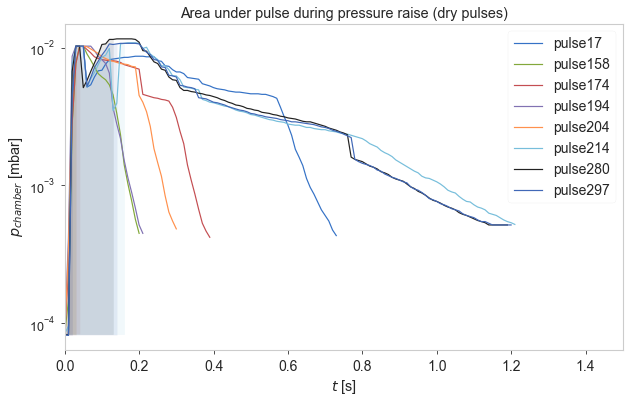

In [143]:
every = 10
Npeaks = len(dryPs.columns)
x = dryPs.index.values/100
plt.figure(figsize=(10, 6))
ax = plt.gca()
for i in dryPs.iloc[:, ::every]:
    col = ax.plot(x, dryPs[i], label=i)[0].get_color()
    mxp = np.argmax(dryPs[i])
    ax.fill_between(x[:mxp], y1=dryPs[i].iloc[0], y2=dryPs[i].iloc[:mxp], color=col, alpha=0.1)
ax.set_xlim(0, 1.5)
cosmetics_aliplot()
ax.set_title('Area under pulse during pressure raise (dry pulses)')

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


Text(0.5, 1.0, 'Area under pulse during pressure raise (wet pulses)')

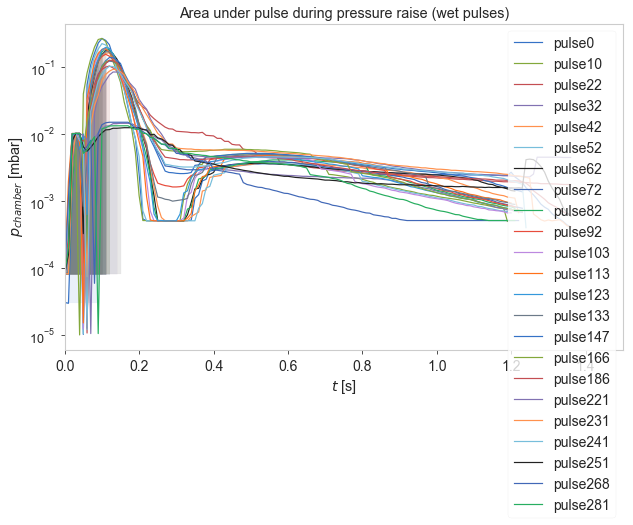

In [479]:
every = 10
Npeaks = len(wetPs.columns)
x = wetPs.index.values/100
plt.figure(figsize=(10, 6))
ax = plt.gca()
for i in wetPs.iloc[:, ::every]:
    col = ax.plot(x, wetPs[i], label=i)[0].get_color()
    mxp = np.argmax(wetPs[i])
    ax.fill_between(x[:mxp], y1=wetPs[i].iloc[0], y2=wetPs[i].iloc[:mxp], color=col, alpha=0.1)
ax.set_xlim(0, 1.5)
cosmetics_aliplot()
ax.set_title('Area under pulse during pressure raise (wet pulses)')

In [153]:
def area_raise(dfp : pd.DataFrame) -> list:
    """Numerical integration of pulses until array maximum (peak)"""
    # For one pulse:
    # np.trapz(dfp.pulse0.iloc[:dfp.pulse0.idxmax()], x=dfp.pulse0.index[:dfp.pulse0.idxmax()]/100 )
    upAreas = [np.trapz(dfp[p].iloc[:dfp[p].idxmax()], x=dfp[p].index[:dfp[p].idxmax()]/100 ) for p in dfp]
    return upAreas

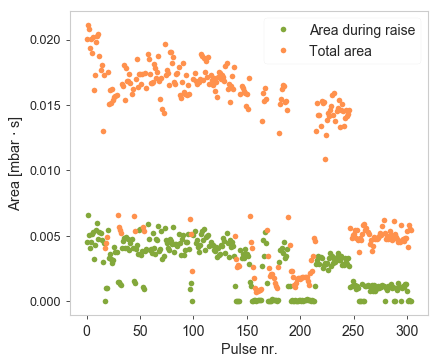

In [154]:
# areas = [np.trapz(dfp[pul].dropna(), x=dfp[pul].dropna().index/100) for pul in dfp]

# upAreas = [np.trapz(dfp[p].iloc[:dfp[p].idxmax()], x=dfp[p].index[:dfp[p].idxmax()]/100 ) for p in dfp]
upAreas = area_raise(dfp)
plt.plot(upAreas, 'o', color='g', label='Area during raise')

plt.plot(areas, 'o', color='y', label='Total area')
plt.xlabel('Pulse nr.')
plt.ylabel('Area [mbar $\cdot$ s]')
plt.legend(loc='upper right')

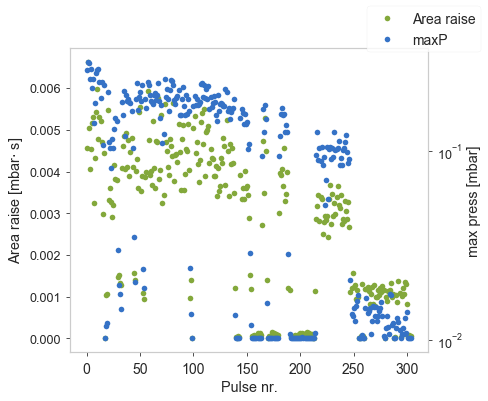

In [152]:
ax = plt.gca()
ax.plot(upAreas, 'o', color='g', label='Area raise')
# ax.plot(areas, 'o', color='y', label='Total area')

ax.set_ylabel('Area raise [mbar$\cdot$ s]')
ax.set_xlabel('Pulse nr.')

ax2 = plt.twinx(ax)

plot_maxP(dfp, ax=ax2, flag_p=True, lb='maxP');
np.trapz(dfp.pulse0.iloc[:dfp.pulse0.idxmax()], x=dfp.pulse0.index[:dfp.pulse0.idxmax()]/100 )
ax2.set_ylabel('max press [mbar]')

plt.gcf().legend(loc='upper right')

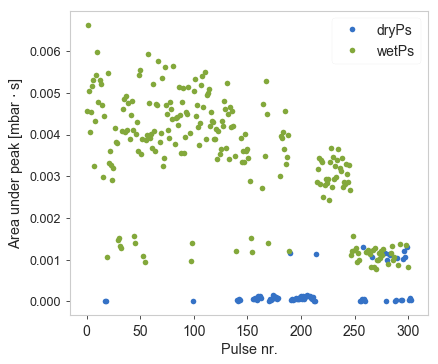

In [166]:
dryArea = area_raise(dryPs)
wetArea = area_raise(wetPs)
dryId = [int(p.replace('pulse', '')) for p in dryPs.columns]
wetId = [int(p.replace('pulse', '')) for p in wetPs.columns]

plt.plot(dryId, dryArea, 'o', label='dryPs')
plt.plot(wetId, wetArea, 'o', label='wetPs')
plt.xlabel('Pulse nr.')
plt.ylabel('Area under peak [mbar $\cdot$ s]')
plt.legend(loc='upper right')

## Injected volume/molecules per pulse

In [ ]:
def table_vnm_pulses(Ntot : int, Nwet : int,
                     C : float, M_ba : float, Vload : float = 0):   
    """
    Table Volume, Number of molecules and mass injected per load, pulse 
    and wet pulse (assuming all solution injected only in wet pulse)
    Input:
    Ntot : total number of pulses
    Nwet : total number of wet pulses
    C : solution concentration (specify units)
        example: C = 0.5 * milimole / liter # example
    M_ba : molecular mass [specify units]
        example: M_ba = 336.24 * gram/mol # molec mass [g/mol] for Ba(ClO4)2
    Vload : volume of ALI load (default 0.3 ml)
    """
    from invisible_cities.core.system_of_units import ml, liter
    from invisible_cities.core.system_of_units import milimole, mol, gram, milligram
    NA = 6.023e23 # Avogadro constant [molec/mol]
    
    if Vload == 0: Vload = 0.3 * ml

    vols = (Vload / ml, Vload / Ntot / ml, Vload / Nwet / ml)
    Nmolecs = tuple([v * C / milimole * NA for v in vols])
    masses = tuple([v * C / milimole * M_ba / gram for v in vols])

    print(' \t total load \t per pulse \t per wet pulse')
    print('V [mL]\t %.2e \t %.2e \t %.2e' %(vols))
    print('N \t %.2e \t %.2e \t %.2e' %(Nmolecs))
    print('m [g] \t %.2e \t %.2e \t %.2e' %(masses))
    

In [204]:
C = 0.5 * milimole / liter
M_ba = 336.24 * gram/mol # molec mass [g/mol] for Ba(ClO4)2
Nwet = len(wetPeaks.columns)
Ntot = len(dfp.columns)
 
table_vnm_pulses(Ntot, Nwet, C, M_ba)

 	 total load 	 per pulse 	 per wet pulse
V [mL]	 3.00e-01 	 9.84e-04 	 1.31e-03
N 	 9.03e+16 	 2.96e+14 	 3.95e+14
m [g] 	 5.04e-05 	 1.65e-07 	 2.20e-07


In [ ]:
def subl_nba(d_pel = 1.3 * cm, thick = 100 * nm):
    """For a pellet with 1.3 cm diameter compute number of barium molecules from thickness [in cm]
    Input: film thickness from QMB [cm]"""
    
    M_ba = 336.24 * gram/mol # molec mass [g/mol]
    p_ba = 3.2 * gram/cm3 # molecular density [g/cm^3]
    NA = 6.023e23 # Avogadro constant [molec/mol]
    
    S_pel = np.pi*(d_pel/2)**2 # pellet area [cm^2]

    V_ba = thick * S_pel
    m_ba = V_ba * p_ba # Deposited mass
    N_ba = NA * m_ba / M_ba # Number of molecules deposited
    print(f'Total number of Barium perchlorate molecules deposited ={N_ba:.2e}')
    return m_ba, N_ba

In [487]:
maxP

array([0.26702099, 0.29601483, 0.29051852, 0.23862037, 0.26953504,
       0.21524816, 0.24086702, 0.13987095, 0.17846086, 0.25719713,
       0.26702099, 0.26953504, 0.22984138, 0.19056   , 0.23200538,
       0.10759014, 0.22138537, 0.01023874, 0.01178403, 0.01223413,
       0.20347943, 0.11169964, 0.10363183, 0.08122276, 0.11488445,
       0.10363183, 0.1297684 , 0.14935381, 0.14385899, 0.02979933,
       0.01936398, 0.01746733, 0.01448205, 0.18183715, 0.15361223,
       0.20732905, 0.11927256, 0.1978386 , 0.18354918, 0.18702174,
       0.18014109, 0.17846086, 0.16249677, 0.10363183, 0.03494568,
       0.0201036 , 0.18878258, 0.22769757, 0.1640267 , 0.19235415,
       0.20539522, 0.18354918, 0.22346975, 0.0235755 , 0.01882718,
       0.18878258, 0.16870347, 0.22984138, 0.22346975, 0.1978386 ,
       0.18354918, 0.18183715, 0.17679629, 0.19599329, 0.2015815 ,
       0.18527732, 0.1978386 , 0.22769757, 0.18354918, 0.14935381,
       0.17514725, 0.10962563, 0.12267329, 0.23862037, 0.19235

## Leaked mass

### Effective pumping speed: gaussian fit

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Wet pulses')

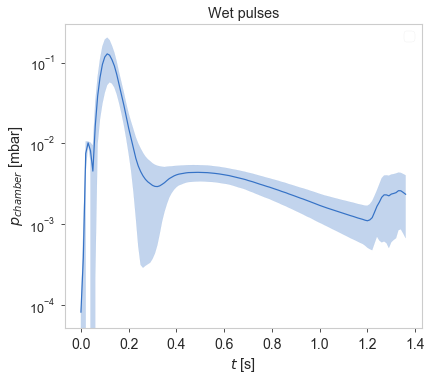

In [101]:
plotAverageProfile(wetPs)
plt.title('Wet pulses')

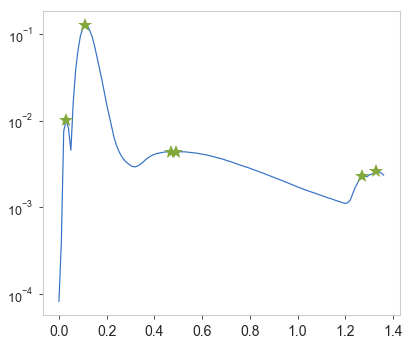

In [342]:
avWet, sdWet, _ = avCurves(wetPs)
from peakutils import indexes
peakId = indexes(avWet, thres=1e-3, thres_abs=True)
ppeak = [avWet[p] for p in peakId]
tpeak = peakId/100
x = np.arange(len(avWet))/100
plt.plot(x, avWet)
plt.plot(tpeak, ppeak, '*', ms=15)
plt.yscale('log')


array([9.97221278e-02, 3.36243838e+02, 3.96078215e-03, 5.06797890e+01])

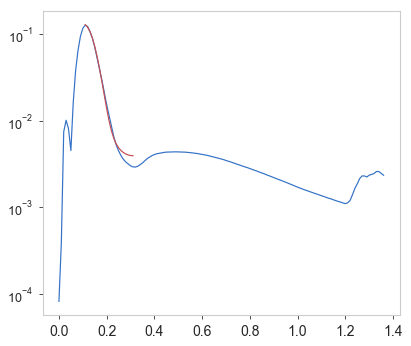

In [302]:
trough = np.argmin(avWet[peakId[1]:peakId[2]]) + peakId[1]
xpump = x[peakId[1]:trough]
ppump = avWet[peakId[1]:trough]
# plt.semilogy(xpump, ppump)
plt.semilogy(x, avWet)

from scipy.optimize import curve_fit
def exp(x, p0, tau, p1, beta):
    return p0*np.exp(-tau*(x-x[0])**2) + p1*np.exp(beta*(x-x[-1])**2)

fit, cov = curve_fit(exp, xpump, ppump, p0=[ppump[0], 1, -ppump[-1], 5])
plt.semilogy(xpump, exp(xpump, *fit), '-r')
fit

array([0.00416666, 3.37244211])

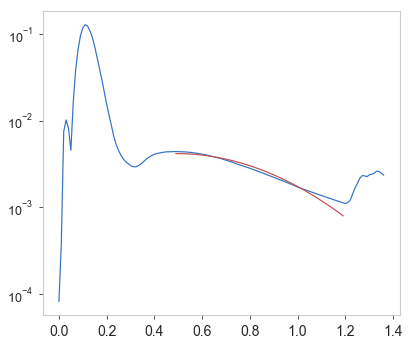

In [283]:
trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]
xpump = x[peakId[3]:trough2]
ppump = avWet[peakId[3]:trough2]
# plt.semilogy(xpump, ppump)
plt.semilogy(x, avWet)

from scipy.optimize import curve_fit
def exp(x, p0, tau):
    return p0*np.exp(-tau*(x-x[0])**2)

fit, cov = curve_fit(exp, xpump, ppump, p0=[ppump[0], 1])
plt.semilogy(xpump, exp(xpump, *fit), '-r')
fit

In [284]:
ppump[0]

0.0043937393930131

array([ 4.87789201e-03,  2.21564587e+00, -3.69780338e-06,  8.44378724e+00])

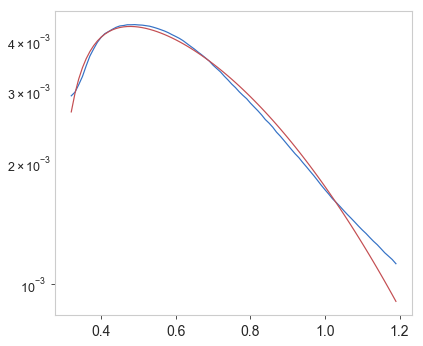

In [310]:
trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]
xpump = x[trough:trough2]
ppump = avWet[trough:trough2]
plt.semilogy(xpump, ppump)
# plt.semilogy(x, avWet)

from scipy.optimize import curve_fit
def exp(x, p0, tau, p1, beta):
    return p0*np.exp(-tau*(x-x[0])**2) + p1*np.exp(beta*(x-x[-1])**2)

fit, cov = curve_fit(exp, xpump, ppump, p0=[np.max(ppump), 1, -ppump[-1], 5])
plt.semilogy(xpump, exp(xpump, *fit), '-r')
fit

array([4.45451709e-03, 1.68996782e+01])

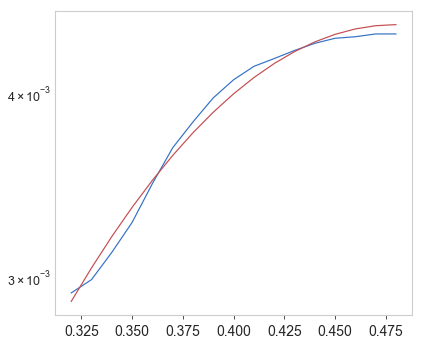

In [259]:
trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]
xpump = x[trough:peakId[3]]
ppump = avWet[trough:peakId[3]]
plt.semilogy(xpump, ppump)
# plt.semilogy(x, avWet)

from scipy.optimize import curve_fit
def exp(x, p0, tau):
    return p0*np.exp(-tau*(x-x[-1])**2)# + p1*np.exp(beta*(x-x[0]))

fit, cov = curve_fit(exp, xpump, ppump, p0=[np.max(ppump), 1])#, ppump[0], 5])
plt.semilogy(xpump, exp(xpump, *fit), '-r')
fit

In [316]:
ppump[peakId[3]-peakId[1]], avWet[peakId[3]]

(0.0043937393930131, 0.0043937393930131)

In [322]:
xpump[trough-peakId[1]]

0.32

array([ 7.49642660e-02,  2.33830247e+02,  4.09743472e-03, -1.67713253e+00,
        4.94065114e-02,  7.20587313e+02])

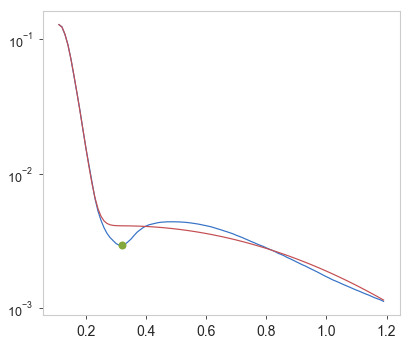

In [328]:
trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]
xpump = x[peakId[1]:trough2]
ppump = avWet[peakId[1]:trough2]
plt.semilogy(xpump, ppump)
# plt.semilogy(x, avWet)

from scipy.optimize import curve_fit
def exp(x, p0, tau, p1, beta, p2, gamma):
    return p0*np.exp(-tau*(x-x[0])**2) + p1*np.exp(beta*(x-0.32)**2) + p2*np.exp(-gamma*(x-x[0])**2)

fit, cov = curve_fit(exp, xpump, ppump, p0=[np.max(ppump), 65, ppump[peakId[3]-peakId[1]], -2, ppump[-1], 8])
plt.semilogy(xpump, exp(xpump, *fit), '-r')
plt.plot(xpump[trough-peakId[1]], ppump[trough-peakId[1]], 'o', ms=8)

fit

array([-3.77770346e+00,  3.34240377e-02,  1.18370536e-01, -5.06415840e+02,
        3.78352786e+00,  9.49617933e-02])

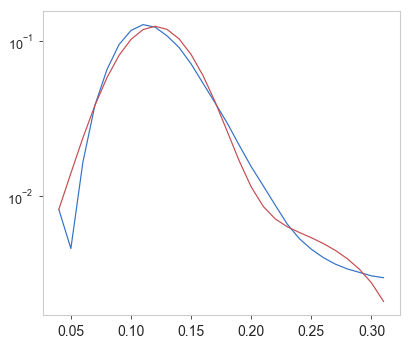

In [340]:
trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]
xpump = x[peakId[0]+1:trough]
ppump = avWet[peakId[0]+1:trough]
plt.semilogy(xpump, ppump)
# plt.semilogy(x, avWet)

from scipy.optimize import curve_fit
# def exp(x, p0, tau, p1, beta):
#     return p0*np.exp(-tau*(x-x[0])**2) + p1*np.exp(beta*(x-x[-1])**2)

# fit, cov = curve_fit(exp, xpump, ppump, p0=[np.max(ppump), 1, -ppump[-1], 5])
def exp(x, p0, tau, p1, beta, p2, gamma):
    return p0*np.exp(-tau*(x-x[0])**2) + p1*np.exp(beta*(x-0.12)**2) + p2*np.exp(-gamma*(x-0.12)**2)

fit, cov = curve_fit(exp, xpump, ppump, p0=[np.max(ppump), 88, ppump[peakId[1]-peakId[0]], -54, ppump[-1], 60])

plt.semilogy(xpump, exp(xpump, *fit), '-r')
fit

### Pumping speed: fit to exp + $t^{-n}$

array([ 3.27629693e-01,  3.00783605e+01, -2.13524263e-07,  6.23041522e+00])

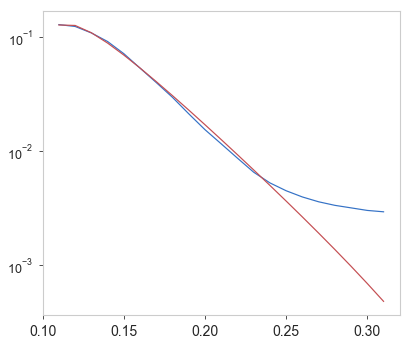

In [392]:
trough = np.argmin(avWet[peakId[1]:peakId[2]]) + peakId[1]
xpump = x[peakId[1]:trough]
ppump = avWet[peakId[1]:trough]
plt.semilogy(xpump, ppump)
# plt.semilogy(x, avWet)

from scipy.optimize import curve_fit
def exp(x, p0, tau, p1, beta):
    return p0*np.exp(-tau*(x-x[0])) + p1/(x)**beta

fit, cov = curve_fit(exp, xpump, ppump, p0=[ppump[0], 30, ppump[-1], 0.1])
plt.semilogy(xpump, exp(xpump, *fit), '-r')
fit

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([8.21240349e-05, 1.20542385e+04, 1.37028291e+01, 2.14523682e+00])

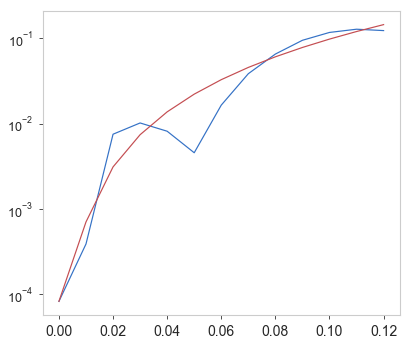

In [447]:
trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]
xpump = x[:peakId[1]+2]
ppump = avWet[:peakId[1]+2]

plt.semilogy(xpump, ppump)
# plt.semilogy(x, avWet)

from scipy.optimize import curve_fit
def exp(x, p0, tau, p1, beta):
    return p0*np.exp(-tau*(x)) +  p1*(x)**beta

fit, cov = curve_fit(exp, xpump, ppump, p0=[np.min(ppump), 30, 300, 3])

plt.semilogy(xpump, exp(xpump, *fit), '-r')
fit

No handles with labels found to put in legend.
/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(array([ 8.95963110e+00,  3.00783811e+01, -2.13457443e-07, -6.23054109e+00]),
 array([8.21240349e-05, 1.20542385e+04, 1.37028291e+01, 2.14523682e+00]),
 array([ 0.00743367,  0.59490616, -0.00226704,  1.11268862]))

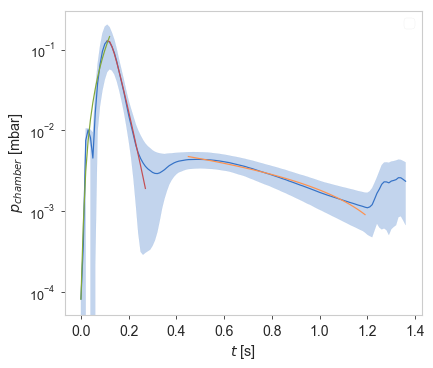

In [463]:
trough = np.argmin(avWet[peakId[1]:peakId[2]]) + peakId[1]
trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]

xdown = x[peakId[1]:trough]
pdown = avWet[peakId[1]:trough]
xup = x[:peakId[1]+2]
pup = avWet[:peakId[1]+2]

plotAverageProfile(wetPs)

from scipy.optimize import curve_fit
def exp(x, p0, tau, p1, n):
    return p0*np.exp(-tau*(x)) + p1*(x)**n

fitDw, covDw = curve_fit(exp, xdown, pdown, p0=[pdown[0], 30, pdown[-1], 0.1])
plt.semilogy(xdown[:-4], exp(xdown[:-4], *fitDw), '-r')

fitUp, covUp = curve_fit(exp, xup, pup, p0=[np.min(pup), 30, 300, 3])
plt.semilogy(xup, exp(xup, *fitUp), '-g')

xOgas = x[peakId[3]-4:trough2]
pOgas = avWet[peakId[3]-4:trough2]
# plt.semilogy(xOgas, pOgas)

fitOgas, covOgas = curve_fit(exp, xOgas, pOgas, p0=[pOgas[0], 2, -pOgas[-1], -1])
plt.semilogy(xOgas, exp(xOgas, *fitOgas), '-y')
fitDw, fitUp, fitOgas

array([ 0.00743367,  0.59490616, -0.00226704,  1.11268862])

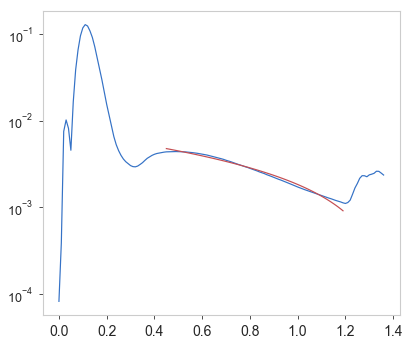

In [461]:
trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]
xOgas = x[peakId[3]-4:trough2]
pOgas = avWet[peakId[3]-4:trough2]
# plt.semilogy(xOgas, pOgas)
plt.semilogy(x, avWet)

fit, cov = curve_fit(exp, xOgas, pOgas, p0=[pOgas[0], 2, -pOgas[-1], -1])
plt.semilogy(xOgas, exp(xOgas, *fit), '-r')
fit

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in multiply
  if sys.path[0] == '':


(array([ 1.24647208e+01,  2.75747406e+01, -7.28410794e-05, -3.98914445e+00,
         1.63977013e-02,  2.15835514e+00]),)

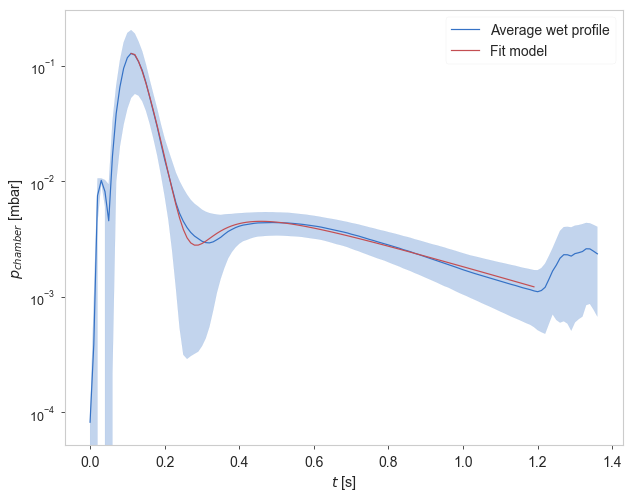

In [476]:
plt.figure(figsize=(10, 8))
trough = np.argmin(avWet[peakId[1]:peakId[2]]) + peakId[1]
trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]

xdown = x[peakId[1]:trough2]
pdown = avWet[peakId[1]:trough2]

plotAverageProfile(wetPs, lb='Average wet profile')

from scipy.optimize import curve_fit
def exp2(x, p0, tau, p1, n, p2, beta):
    return p0*np.exp(-tau*(x)) + p1*(x)**n + p2*np.exp(-beta*x)

fitDw, covDw = curve_fit(exp2, xdown, pdown, p0=[pdown[0], 30, pdown[-1], 0.1, 5e-3, 0.5])
plt.semilogy(xdown, exp2(xdown, *fitDw), '-r', label='Fit model')
plt.legend()
fitDw, #np.sqrt(np.diag(covDw))

In [ ]:
def fit_pump_profile(dfp : pd.DataFrame(), xdown : list, pdown : list):
    """Fit custom model to average pumping profile of ALI curve
    Model is the sum of two exponential with different decay and a negative power of t
    Input:
    --------
    dfp : ALI curve to extract the average profile
    xdown : array of descend time to perform fit on
    pdown : array of descend pressure to perform fit on"""
    
    plotAverageProfile(dfp, lb='Average wet profile')

    from scipy.optimize import curve_fit
    def exp2(x, p0, tau, p1, n, p2, beta):
        return p0*np.exp(-tau*(x)) + p1*(x)**n + p2*np.exp(-beta*x)

    fitDw, covDw = curve_fit(exp2, xdown, pdown, p0=[pdown[0], 30, pdown[-1], 0.1, 5e-3, 0.5])
    plt.semilogy(xdown, exp2(xdown, *fitDw), '-r', label='Fit model')
    plt.legend()
    return fitDw, #np.sqrt(np.diag(covDw))

### $S_0$ and $S_{eff}$

In [551]:
Vcham = 235/50

S0 = Vcham*fitDw[1]
C0 = 0.26
Seff = 1/(1/S0+1/C0)
S0, Seff, Vcham

(137.64178302887555, 0.25950979604095586, 4.7)

### Leak rate

In [548]:
def avLeakMass (wetP : pd.DataFrame(),
                M : float = 41.05,
                Seff : float = 0.25) :
    """Integrate area under ALI pressure curves and compute leak rate and leaked mass.
        Parameters
        ----------
        wetP : ALI pandas.Dataframe (wet pulses)
        M : solution/gas molarity
        Seff : pumping effective speed. Default value 0.25 for C0 = 0.26
        Returns
        ----------
        leak_mass : average leaked mass in gramm
        ql : average leak rates per pulse [mbar*L/s]
    """

    logtime = 0.01 # [10 ms]
    T = 25+273 # Pulse valve temperature [K]
    R = 83.144598 # Gas constant [L⋅mbar⋅K−1⋅mol−1]

    avWet, sdWet, _ = avCurves(wetP, )
    wetArea = area_raise(wetP)
    dt = np.argmax(avWet)/100
    
    ql = np.average(wetArea) * Seff
    leak_mass = ql * dt * M / (R*T)
    return leak_mass, ql

In [552]:
avLeakMass(wetPs, Seff=Seff)

(1.6379168460705293e-07, 0.0008987446227824315)

# Run 2: 1000 pulses

In [488]:
exp4 = import_peaks(files[2])
dfp4 = exp4.dfp

In [491]:
files[2]

'../../ali_data/Ba(ClO4)2_shooting/processed_peaks/24112019_baclo42_FBI_silica_26mg_50ms_1000mbar_3000pulses.pyk'

(0, 3)

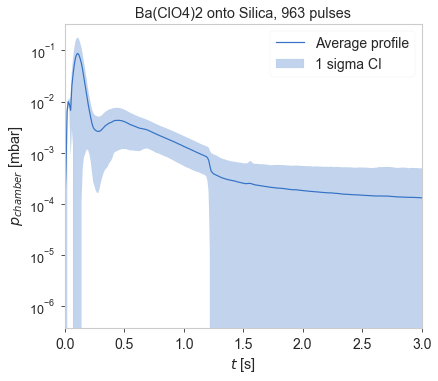

In [489]:
Npeaks = len(dfp4.columns)
plotAverageProfile(dfp4, lb='Average profile', lb2='1 sigma CI')
plt.title('Ba(ClO4)2 onto Silica, {} pulses'.format(Npeaks), )
plt.xlim(0,3)

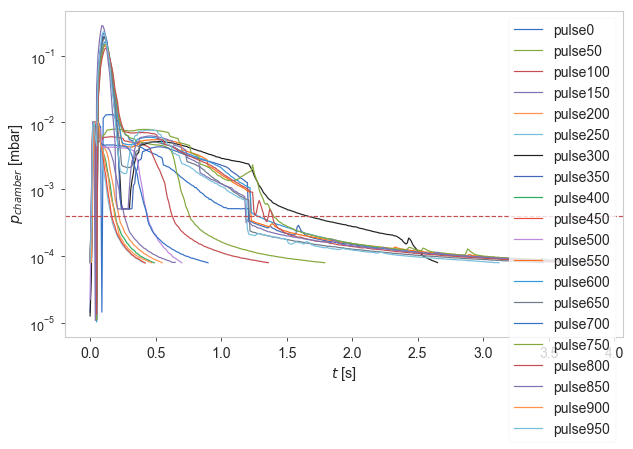

In [490]:
plt.figure(figsize=(10,6))
ax = overplot_every_N_pulses(dfp4, every=50)
ax.axhline(4e-4, ls='--', color='r', label='$p_{thres}$')

Text(0.5, 1.0, 'Sample 4: Peak pressure')

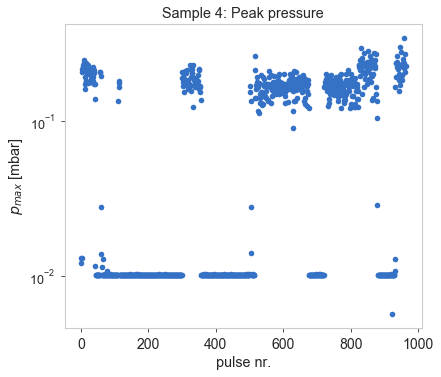

In [498]:
maxP = plot_maxP(dfp4, flag_p=True)
plt.gca().set_title('Sample 4: Peak pressure')

(0, 3)

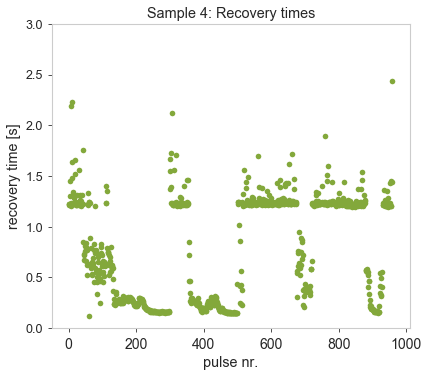

In [527]:
rT = plotRecoveryTimes(dfp4, pAct=4e-4, ax = plt.gca(), col='g');
plt.title('Sample 4: Recovery times')
plt.ylim(0, 3)

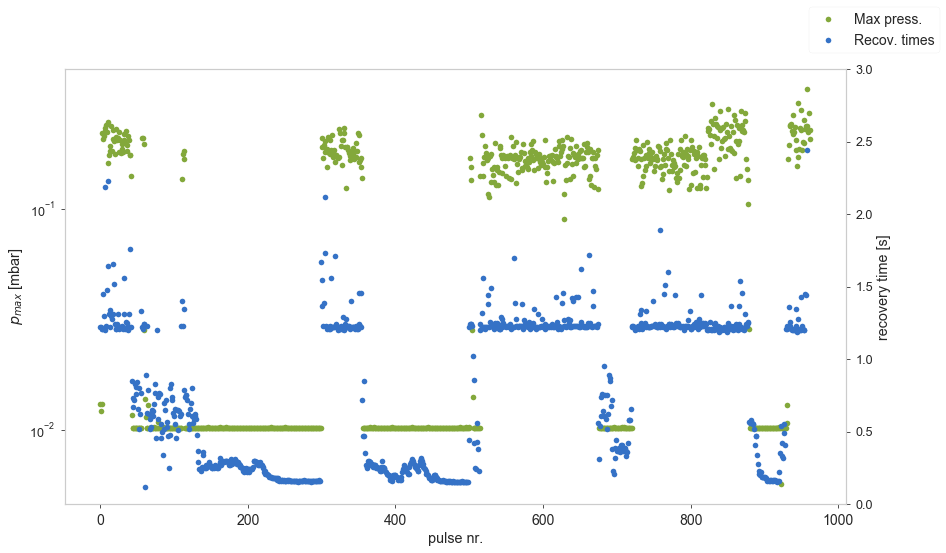

In [499]:
fig = plt.figure(figsize=(14, 8))
ax = plt.gca()
maxP = plot_maxP(dfp4, flag_p=True, ax = ax, col='g', lb='Max press.')
ax2 = plt.twinx(ax)
rT = plotRecoveryTimes(dfp4, pAct=4e-4, ax = ax2, lb='Recov. times')
plt.ylim(0, 3)
plt.gcf().legend()

## Crop until recTime

In [60]:
rP = []
dfshort = pd.DataFrame()
Npeaks = len(dfp4.columns)
for i in dfp4:
    rPt = findRecoveryPoints(dfp4[i], 4e-4, th=5)
    if rPt.any():
        rP.append(rPt[0])
        dfshort[i] = dfp4[i][:rPt[0]]

In [75]:
def shorten_dfp(dfp : pd.DataFrame, pThres : float, inTh : int = 5):
    """Crop dfp of ALI pulse up to time to recover pThres pressure
    Input:
    ---------------
    dfp : ALI pulses df
    pThres : pressure level to recover
    inTh : minimum number of index points
        for recPoints to be separated
        
    Returns:
    dfShort : shortened dfp
    ---------------
    """
    rP = []
    dfShort = pd.DataFrame()
    Npeaks = len(dfp.columns)
    for i in dfp:
        rPt = findRecoveryPoints(dfp[i], pAct=pThres, th=inTh)
        if rPt.any():
            rP.append(rPt[0])
            dfShort[i] = dfp[i][:rPt[0]]
    return dfShort

In [501]:
dfshort = shorten_dfp(dfp4, 4e-4)

No handles with labels found to put in legend.


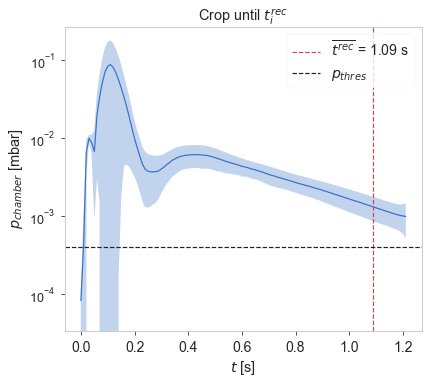

In [502]:
plotAverageProfile(dfshort)
plt.title('Crop until $t^{rec}_i$')
plt.axvline(np.average(rT), ls='--', color='r',
            label='$\overline{t^{rec}}$ = %.2f s' %np.average(rT))
plt.axhline(4e-4, c='k', ls='--', label='$p_{thres}$')

plt.legend(loc='upper right')

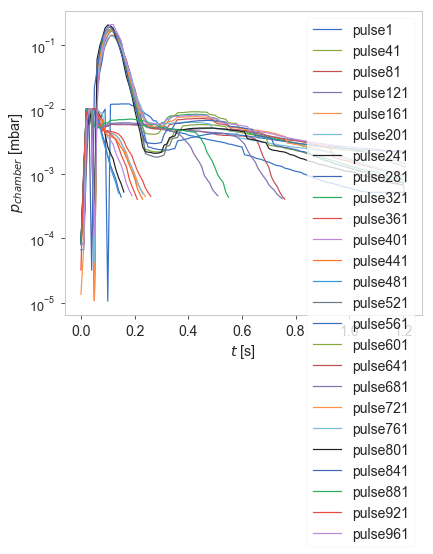

In [504]:
overplot_every_N_pulses(dfshort, every=40)

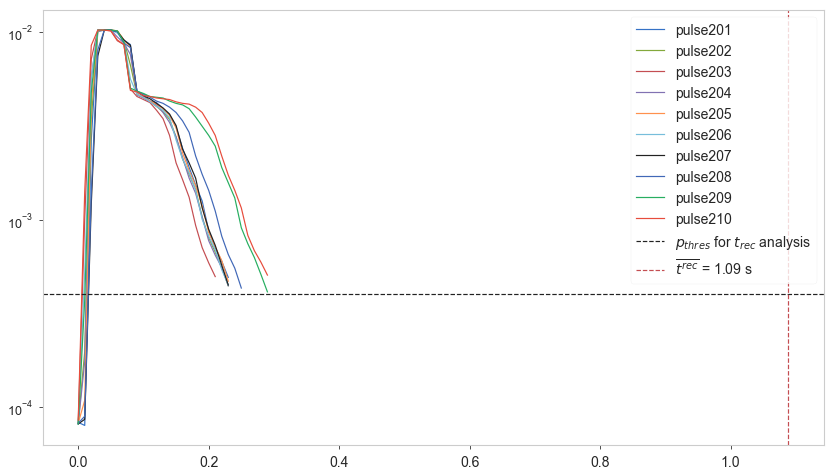

In [65]:
Npeaks = len(dfshort.columns)
x = dfshort.index.values/100
plt.figure(figsize=(14,8))
for i in dfshort.iloc[:, 200:210]:
    plt.semilogy(x, dfshort[i], label=i)
plt.axhline(4e-4, c='k', ls='--', label='$p_{thres}$ for $t_{rec}$ analysis')
plt.axvline(np.average(rT), ls='--', color='r',
            label='$\overline{t^{rec}}$ = %.2f s' %np.average(rT))
plt.legend(loc='upper right')


## Split dry/wet

Text(0.5, 1.0, 'Run 2: 1000 pulses, average wet/dry pulse')

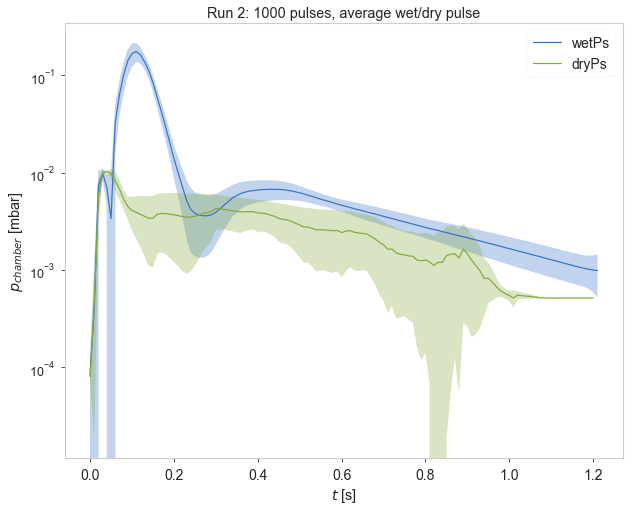

In [508]:
wetP4, dryP4 = split_wet_dry(dfshort, nsigma=0.5)
plt.figure(figsize=(10,8))
plotAverageProfile(wetPs, lb='wetPs')
plotAverageProfile(dryPs, lb='dryPs')
plt.title('Run 2: 1000 pulses, average wet/dry pulse')

Text(0.5, 1.0, 'Compare wet pulses')

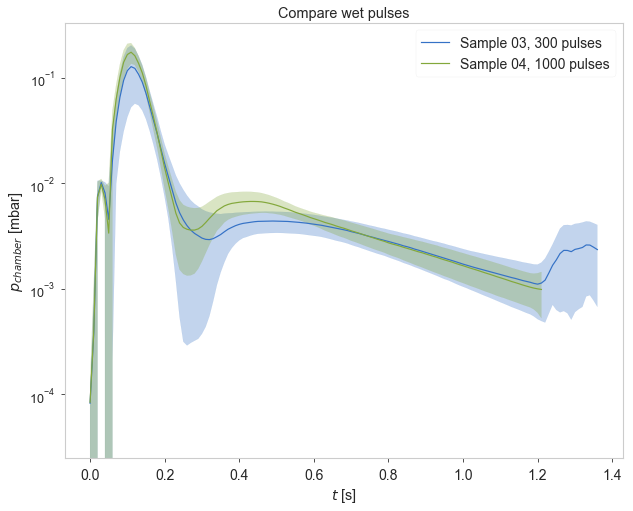

In [520]:
plt.figure(figsize=(10, 8))
plotAverageProfile(wetPs, lb='Sample 03, 300 pulses')
plotAverageProfile(wetP4, lb='Sample 04, 1000 pulses')
plt.title('Compare wet pulses')

Text(0.5, 1.0, 'Compare dry pulses')

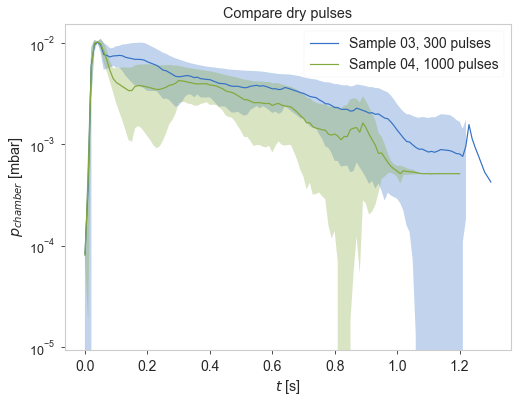

In [516]:
plt.figure(figsize=(8, 6))
plotAverageProfile(dryPs, lb='Sample 03, 300 pulses')
plotAverageProfile(dryP4, lb='Sample 04, 1000 pulses')
plt.title('Compare dry pulses')

In [523]:
len(dryP4.columns), len(wetP4.columns)

(496, 466)

In [531]:
np.average(rT[:-4]), np.std(rT[:-4]), np.average(maxP), np.std(maxP)

(0.7841022964509395,
 0.4990234492452285,
 0.0915318534755971,
 0.08864424031530249)

In [524]:
dryMax = dryPeaks.max(axis=0).values
wetMax = wetPeaks.max(axis=0).values

np.average(dryMax), np.std(dryMax), np.average(wetMax), np.std(wetMax)

(0.010395228565789472,
 0.00037588082170687446,
 0.13272559720087332,
 0.07471161555280806)

## Areas

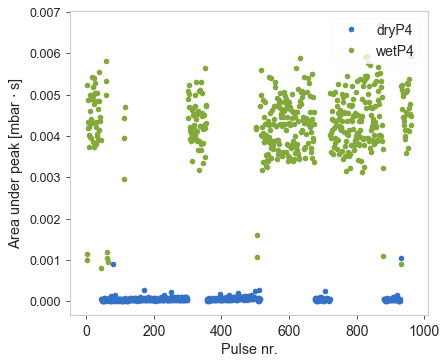

In [532]:
dryArea = area_raise(dryP4)
wetArea = area_raise(wetP4)
dryId = [int(p.replace('pulse', '')) for p in dryP4.columns]
wetId = [int(p.replace('pulse', '')) for p in wetP4.columns]

plt.plot(dryId, dryArea, 'o', label='dryP4')
plt.plot(wetId, wetArea, 'o', label='wetP4')
plt.xlabel('Pulse nr.')
plt.ylabel('Area under peak [mbar $\cdot$ s]')
plt.legend(loc='upper right')

## Injected volume/molecules per pulse 

In [92]:
Nwet

403

In [534]:
C = 0.5 * milimole / liter
M_ba = 336.24 * gram/mol # molec mass [g/mol] for Ba(ClO4)2
Nwet = len(wetP4.columns)
Ntot = len(dfp4.columns)
Vload = 0.3 * 5 * ml

table_vnm_pulses(Ntot, Nwet, C, M_ba, Vload=Vload)

 	 total load 	 per pulse 	 per wet pulse
V [mL]	 1.50e+00 	 1.56e-03 	 3.22e-03
N 	 4.52e+17 	 4.69e+14 	 9.69e+14
m [g] 	 2.52e-04 	 2.62e-07 	 5.41e-07


## Total injected molecules (accounting for cross section)

### Maximum cone aperture:
$\theta = \arcsin(l/r)$

where l is the distance from the orifice to the sample and r is the half the internal diameter of  the T-chamber

In [80]:
np.arcsin(4/19)/np.pi*180

12.153197469007868

##### This is similar to the maximum angle measured by Jesus Sobrado

In [82]:
np.arcsin(77.8/191.3)/np.pi*180

23.99714122341594

### Deposition cross section
$\epsilon = \frac{ r_{pellet}^2 }{ r_{chamber}^2 }$

In [81]:
eff = 0.65**2 / 4**2
eff

0.026406250000000003

### Total injected molecules

In [100]:
print('%.2e'%(N_ba * Nwet * eff))

2.39e+15


## Leaked mass

### Pumping speed

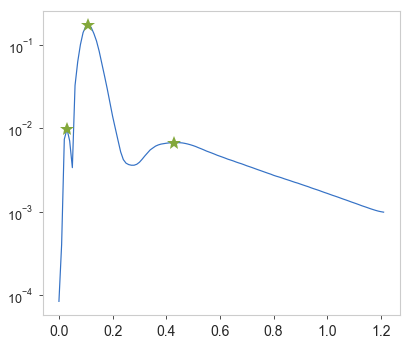

In [535]:
avWet, sdWet, _ = avCurves(wetP4)
from peakutils import indexes
peakId = indexes(avWet, thres=1e-3, thres_abs=True)
ppeak = [avWet[p] for p in peakId]
tpeak = peakId/100
x = np.arange(len(avWet))/100
plt.plot(x, avWet)
plt.plot(tpeak, ppeak, '*', ms=15)
plt.yscale('log')


/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


(array([ 2.25730076e+01,  2.92854858e+01, -1.21033672e-04, -3.95787474e+00,
         3.87688375e-02,  3.16879368e+00]),)

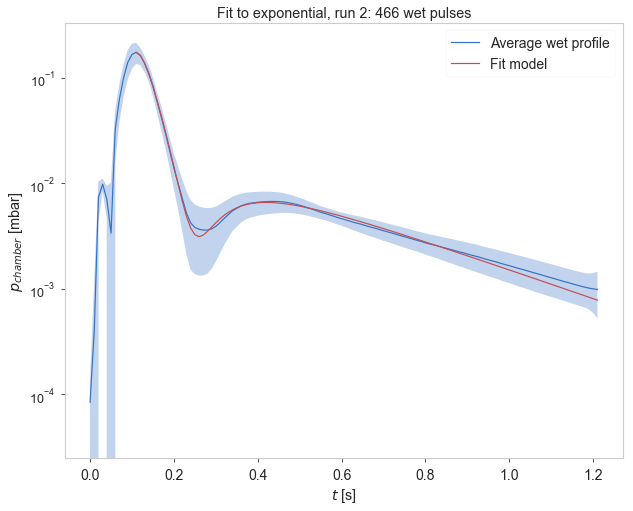

In [538]:
plt.figure(figsize=(10, 8))
trough = np.argmin(avWet[peakId[1]:peakId[2]]) + peakId[1]
# trough2 = np.argmin(avWet[peakId[3]:peakId[4]]) + peakId[3]

xdown = x[peakId[1]:]
pdown = avWet[peakId[1]:]

plotAverageProfile(wetP4, lb='Average wet profile')

from scipy.optimize import curve_fit
def exp2(x, p0, tau, p1, n, p2, beta):
    return p0*np.exp(-tau*(x)) + p1*(x)**n + p2*np.exp(-beta*x)

fitDw, covDw = curve_fit(exp2, xdown, pdown, p0=[pdown[0], 30, pdown[-1], 0.1, 5e-3, 0.5])
plt.semilogy(xdown, exp2(xdown, *fitDw), '-r', label='Fit model')
plt.legend()
plt.title('Fit to exponential, run 2: 466 wet pulses')
fitDw, #np.sqrt(np.diag(covDw))

In [544]:
var = ['p_1','tau_1 [s^{-1}]', 'k', 'n', 'p_2', 'tau_2 [s^{-1}]']
for v, r in zip (var, fitDw):
    if 'tau' in v:
        print(v + '\t %.2e'%r)        
    else:
        print(v + '\t\t %.2e'%r)

p_1		 2.26e+01
tau_1 [s^{-1}]	 2.93e+01
k		 -1.21e-04
n		 -3.96e+00
p_2		 3.88e-02
tau_2 [s^{-1}]	 3.17e+00


In [553]:
Vcham = 235/50

S0 = Vcham*fitDw[1]
C0 = 0.26
Seff = 1/(1/S0+1/C0)
S0, Seff, Vcham

(137.64178302887555, 0.25950979604095586, 4.7)

### Leaked mass

In [554]:
avLeakMass(wetP4, Seff=Seff)

(2.0369553630179912e-07, 0.001117701844115122)

# Run 3: 300 pulses

In [5]:
exp1 = import_peaks(files[0])
dfp1 = exp1.dfp

In [7]:
exp1

AliPeaks(dfp=        pulse0    pulse1    pulse2    pulse3    pulse4    pulse5    pulse6  \
0     0.000065  0.000083  0.000084  0.000084  0.000083  0.000083  0.000084   
1     0.000237  0.000335  0.000083  0.000265  0.000375  0.000695  0.000419   
2     0.006907  0.010239  0.006058  0.009064  0.010239  0.009499  0.009679   
3     0.010239  0.010239  0.010239  0.010143  0.010239  0.010239  0.010239   
4     0.009955  0.006231  0.005465  0.009411  0.006002  0.009411  0.009862   
5     0.000193  0.010531  0.007586  0.008100  0.000010  0.009862  0.009679   
6     0.018478  0.024248  0.000010  0.000011  0.030080  0.017632  0.000011   
7     0.035607  0.043351  0.037666  0.030080  0.051800  0.027389  0.031820   
8     0.066091  0.060745  0.061895  0.061895  0.074653  0.046726  0.069913   
9     0.106587  0.080465  0.087546  0.099819  0.109626  0.066713  0.103632   
10    0.132223  0.107590  0.117058  0.126171  0.134725  0.079715  0.129768   
11    0.150760  0.118160  0.135993  0.145213  0.145

In [8]:
dfp1

,pulse0,pulse1,pulse2,pulse3,pulse4,pulse5,pulse6,pulse7,pulse8,pulse9,...,pulse14,pulse15,pulse16,pulse17,pulse18,pulse19,pulse20,pulse21,pulse22,pulse23
0,0.000065,0.000083,0.000084,0.000084,0.000083,0.000083,0.000084,0.000082,0.000084,0.000084,...,0.000082,0.000083,0.000084,0.000084,0.000082,0.000083,0.000084,0.000083,0.000083,0.000682
1,0.000237,0.000335,0.000083,0.000265,0.000375,0.000695,0.000419,0.000083,0.000260,0.000130,...,0.000083,0.000097,0.000083,0.000152,0.000083,0.000847,0.000157,0.000555,0.000081,0.010143
2,0.006907,0.010239,0.006058,0.009064,0.010239,0.009499,0.009679,0.004204,0.010049,0.010049,...,0.001121,0.010143,0.003937,0.007876,0.001775,0.009770,0.010143,0.009770,0.006002,0.010239
3,0.010239,0.010239,0.010239,0.010143,0.010239,0.010239,0.010239,0.010143,0.010239,0.010239,...,0.010239,0.010239,0.010239,0.010239,0.010143,0.010239,0.010239,0.010143,0.010143,0.006408
4,0.009955,0.006231,0.005465,0.009411,0.006002,0.009411,0.009862,0.010239,0.006058,0.005727,...,0.010239,0.005946,0.010239,0.010239,0.010239,0.005363,0.006231,0.005215,0.005313,0.010335
5,0.000193,0.010531,0.007586,0.008100,0.000010,0.009862,0.009679,0.006653,0.008569,0.008100,...,0.005946,0.008980,0.007038,0.008100,0.006289,0.000035,0.008649,0.000054,0.007586,0.018135
6,0.018478,0.024248,0.000010,0.000011,0.030080,0.017632,0.000011,0.000014,0.000010,0.000010,...,0.008100,0.000015,0.002757,0.000014,0.009955,0.019730,0.000010,0.017632,0.002141,0.042149
7,0.035607,0.043351,0.037666,0.030080,0.051800,0.027389,0.031820,0.023356,0.033346,0.033035,...,0.003900,0.037315,0.037315,0.024022,0.000019,0.035275,0.036280,0.033660,0.034620,0.066713
8,0.066091,0.060745,0.061895,0.061895,0.074653,0.046726,0.069913,0.039845,0.059061,0.055311,...,0.034297,0.056358,0.057965,0.036622,0.037315,0.060745,0.056358,0.055832,0.052287,0.089202
9,0.106587,0.080465,0.087546,0.099819,0.109626,0.066713,0.103632,0.074653,0.084325,0.076066,...,0.050838,0.076782,0.085119,0.060745,0.055311,0.089202,0.078235,0.086729,0.075356,0.118160


Text(0.5, 1.0, 'Ba(ClO4)2 onto Silica, 24 pulses')

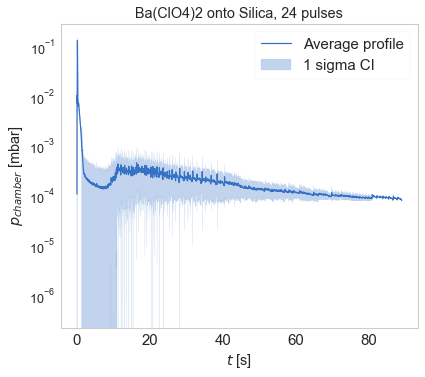

In [9]:
Npeaks = len(dfp1.columns)
plotAverageProfile(dfp1, lb='Average profile', lb2='1 sigma CI')
plt.title('Ba(ClO4)2 onto Silica, {} pulses'.format(Npeaks), )


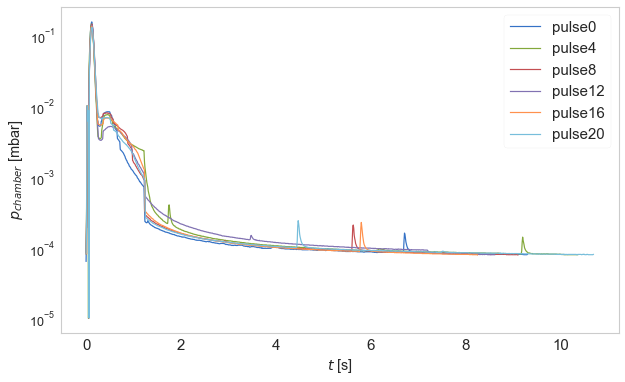

In [11]:
plt.figure(figsize=(10,6))
overplot_every_N_pulses(dfp1, every=4)

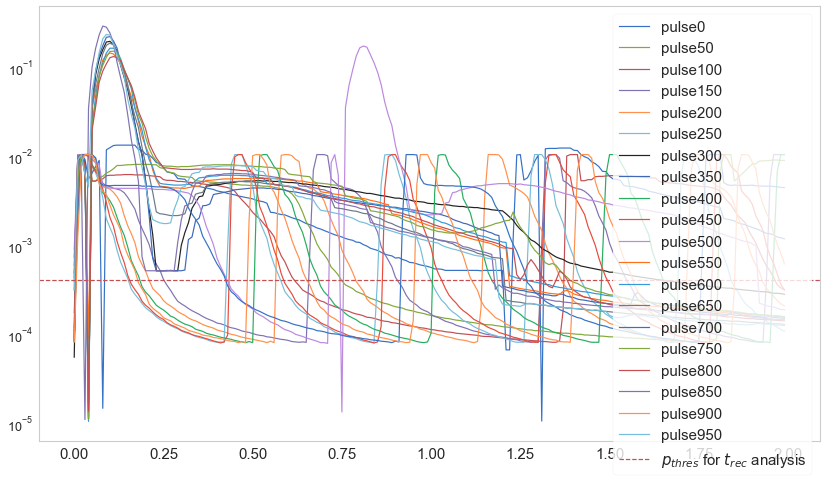

In [7]:
Npeaks = len(dfp4.columns)
x = dfp4.index.values/100
plt.figure(figsize=(14,8))
for i in range(0,Npeaks,50):
    plt.semilogy(x, dfp4['peak'+str(i)], label='pulse'+str(i))
plt.axhline(4e-4, c='r', ls='--', label='$p_{thres}$ for $t_{rec}$ analysis')
plt.legend(loc='upper right')


Text(0.5, 1.0, 'Sample 4: Peak pressure')

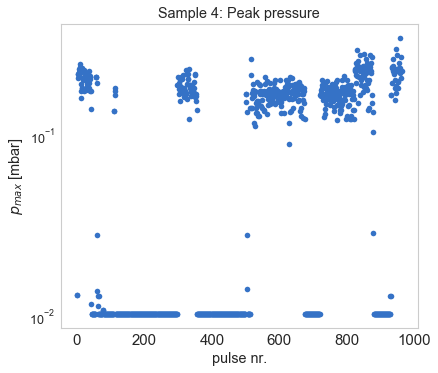

In [23]:
maxP = plot_maxP(dfp4, ax = plt.gca());
plt.title('Sample 4: Peak pressure')

Text(0.5, 1.0, 'Sample 4: Recovery times')

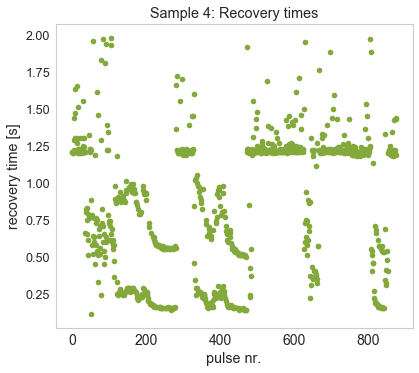

In [59]:
rT = plotRecoveryTimes(dfp4, pAct=4e-4, ax = plt.gca(), col='g');
plt.title('Sample 4: Recovery times')

# Summary

In [57]:
np.average(rT), np.std(rT), np.average(maxP), np.std(maxP)

(1.1455474452554744,
 0.31558177005074894,
 0.10508281849270072,
 0.08398805894576562)

In [59]:
dryMax = dryPeaks.max(axis=0).values
wetMax = wetPeaks.max(axis=0).values

np.average(dryMax), np.std(dryMax), np.average(wetMax), np.std(wetMax)

(0.010358200720588235,
 0.0003149166371186866,
 0.13635113892233008,
 0.07377585400497688)

In [188]:
print('$\overline{t^{rec}}$ [s] \t %.2f $\pm$ %.2f' %(np.average(rT), np.std(rT)))
print('$N^{dry}$ \t\t %i' %len(dryPeaks.columns))
print('$N^{wet}$ \t\t %i' %len(wetPeaks.columns))
print('$\overline{p^{dry}_{max}}$ [mbar] \t %.2e $\pm$ %.2e' %(np.average(dryMax), np.std(dryMax)))
print('$\overline{p^{wet}_{max}}$ [mbar] \t %.2e $\pm$ %.2e' %(np.average(wetMax), np.std(wetMax)))
N_ba, m_ba / gram
print('$N_{Ba}^{wet}$ \t %.2e' %N_ba)
print('$m_{Ba}^{wet}$ [g] \t %.2e' %(m_ba / gram))
print('$A^{dry}$ \t %.2e' %(areaDry))
print('$A^{wet}$ \t %.2e' %(areaWet))

$\overline{t^{rec}}$ [s] 	 1.15 $\pm$ 0.32
$N^{dry}$ 		 68
$N^{wet}$ 		 206
$\overline{p^{dry}_{max}}$ [mbar] 	 1.04e-02 $\pm$ 3.15e-04
$\overline{p^{wet}_{max}}$ [mbar] 	 1.36e-01 $\pm$ 7.38e-02
$N_{Ba}^{wet}$ 	 4.39e+14
$m_{Ba}^{wet}$ [g] 	 2.45e-07
$A^{dry}$ 	 4.22e-03
$A^{wet}$ 	 1.41e-02


In [228]:
res = {'$\overline{t^{rec}}$ [s]' : '%.2f'%np.average(rT) + '$\pm$' + '%.2f'%np.std(rT)}
res['$N^{dry}$'] = len(dryPeaks.columns)
res['$N^{wet}$'] = len(wetPeaks.columns)

res['$\overline{p^{dry}_{max}}$ [mbar]'] = '%.4f'%np.average(dryMax) + '$\pm$' + '%.4f'%np.std(dryMax)
res['$\overline{p^{wet}_{max}}$ [mbar]'] =  '%.2f'%np.average(wetMax) + '$\pm$' + '%.2f'%np.std(wetMax)
res['$N_{Ba}^{wet}$'] = N_ba
res['$m_{Ba}^{wet}$ [g]'] = m_ba / gram
res['$A^{dry}$'] = areaDry
res['$A^{wet}$'] = areaWet
pd.DataFrame([res]).T
#to_csv('~/Desktop/temp.csv')

,0
$A^{dry}$,0.0042197
$A^{wet}$,0.0141202
$N^{dry}$,68
$N^{wet}$,206
$N_{Ba}^{wet}$,4.38568e+14
$\overline{p^{dry}_{max}}$ [mbar],0.0104$\pm$0.0003
$\overline{p^{wet}_{max}}$ [mbar],0.14$\pm$0.07
$\overline{t^{rec}}$ [s],1.15$\pm$0.32
$m_{Ba}^{wet}$ [g],2.44835e-07


In [225]:
from IPython.display import display, Math, Markdown
display(Math('\overline{t^{rec}} [s] | %.2f \pm %.2f' %(np.average(rT), np.std(rT))))
# display(Math('N^{dry} || %i' %len(dryPeaks.columns)))
# display(Math('N^{wet} || %i' %len(wetPeaks.columns)))
# display(Math('\overline{p^{dry}_{max}} [mbar] | %.2e \pm %.2e' %(np.average(dryMax), np.std(dryMax))))
# display(Math('\overline{p^{wet}_{max}} [mbar] | %.2e \pm %.2e' %(np.average(wetMax), np.std(wetMax))))
# display(Math('N_{Ba}^{wet} | %.2e' %N_ba))
# display(Math('m_{Ba}^{wet} [g] | %.2e' %(m_ba / gram)))
# display(Math('A^{dry} | %.2e' %(areaDry)))
# display(Math('A^{wet} | %.2e' %(areaWet)))

<IPython.core.display.Math object>

# Compare to solvent only 

In [35]:
path = '../../ali_data/Acetonitrile/**/*'
files0 = glob.glob(path)
files = []
for f in files0:
    if ('.asc' not in f) and ('50ms' in f):
        files.append(f)
        
files, len(files)

(['../../ali_data/Acetonitrile/200mbar/10072019_Acetonitrile_200mbar_50ms_DwellTime2ms_10pulses_rga',
  '../../ali_data/Acetonitrile/700mbar/10072019_Acetonitrile_700mbar_50ms_DwellTime2ms_10pulses_rga',
  '../../ali_data/Acetonitrile/500mbar/01102019_deposition_AcN_only_510mbar_50ms_5pulse',
  '../../ali_data/Acetonitrile/500mbar/10072019_Acetonitrile_500mbar_50ms_DwellTime2ms_10pulses_rga',
  '../../ali_data/Acetonitrile/1000mbar/10072019_Acetonitrile_1000mbar_50ms_DwellTime2ms_10pulses_rga'],
 5)

In [46]:
path = '../../ali_data/27022019_gasonly_1000mbar_10ms'

No handles with labels found to put in legend.


[array([  103,  3104,  6105,  9106, 12106, 15108, 18109, 21110, 24111,
        27120, 30121, 33122, 36123, 39124, 42125]),
 array([   98,  3099,  6096,  9101, 12102, 14908, 18102, 20848, 24106,
        26965, 29952, 33117, 36118, 39098, 41953])]

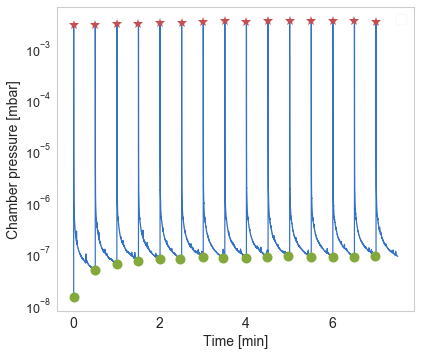

In [47]:
dfRaw = load_raw_ali_df(path)
plot_pressure_curve(dfRaw, tit='')

In [48]:
dfp_ar = process_dfRaw_peaks(path, peakLength=100)

In [36]:
for f in files:
    dfp_acn = process_dfRaw_peaks(path = f, peakLength=100)
    save_processed_peaks(f, dfp_acn)

Saving processed peaks df to  ../../ali_data/Acetonitrile/200mbar/processed_peaks/10072019_Acetonitrile_200mbar_50ms_DwellTime2ms_10pulses_rga.pyk
Saving processed peaks df to  ../../ali_data/Acetonitrile/700mbar/processed_peaks/10072019_Acetonitrile_700mbar_50ms_DwellTime2ms_10pulses_rga.pyk
Saving processed peaks df to  ../../ali_data/Acetonitrile/500mbar/processed_peaks/01102019_deposition_AcN_only_510mbar_50ms_5pulse.pyk
Saving processed peaks df to  ../../ali_data/Acetonitrile/500mbar/processed_peaks/10072019_Acetonitrile_500mbar_50ms_DwellTime2ms_10pulses_rga.pyk
Saving processed peaks df to  ../../ali_data/Acetonitrile/1000mbar/processed_peaks/10072019_Acetonitrile_1000mbar_50ms_DwellTime2ms_10pulses_rga.pyk


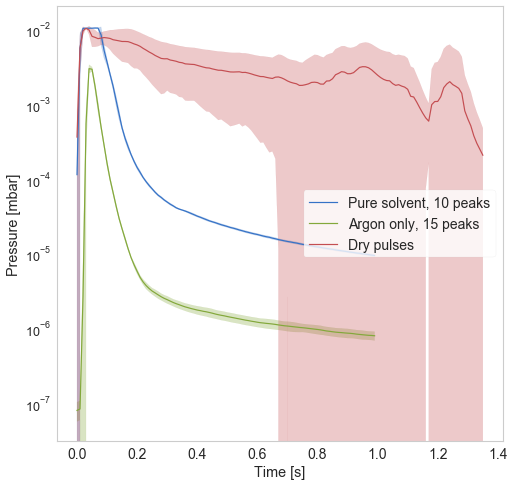

In [55]:
plt.figure(figsize=(8, 8))
plotAverageProfile(dfp_acn, lb='Pure solvent, 10 peaks')
plotAverageProfile(dfp_ar, lb='Argon only, 15 peaks')
plotAverageProfile(dryPeaks, lb='Dry pulses')
plt.legend(loc='center right')

### Other cleaning files

In [207]:
path = '../../ali_data/depletion_cleaning/**/*'
files0 = glob.glob(path)
files = []
for f in files0:
    if ('.asc' not in f) and ('50ms' in f):
        files.append(f)
        
files, len(files)

(['../../ali_data/depletion_cleaning/DCM/15012020_depletion_CH2Cl2_200mbar_50ms_200pulses_300uL',
  '../../ali_data/depletion_cleaning/DCM/28102019_depletion_CH2Cl2_1000mbar_50ms_300pulses_300uL',
  '../../ali_data/depletion_cleaning/processed_peaks/21102019_depletion_AcN_FBI_1uM_200mbar_50ms_300pulse.pyk',
  '../../ali_data/depletion_cleaning/processed_peaks/26072019_Depletion_200mbar_50ms_500pulses_rga.pyk',
  '../../ali_data/depletion_cleaning/processed_peaks/10102019_depletion_AcN_FBI_500nM_350mbar_50ms_300pulse.pyk',
  '../../ali_data/depletion_cleaning/processed_peaks/27092019_depletion_AcN_FBI_500nM_cleaning_570mbar_50ms_300pulse.pyk'],
 6)

In [219]:
exp_acn = import_peaks(files[2])
dfp_acn = exp_acn.dfp

No handles with labels found to put in legend.


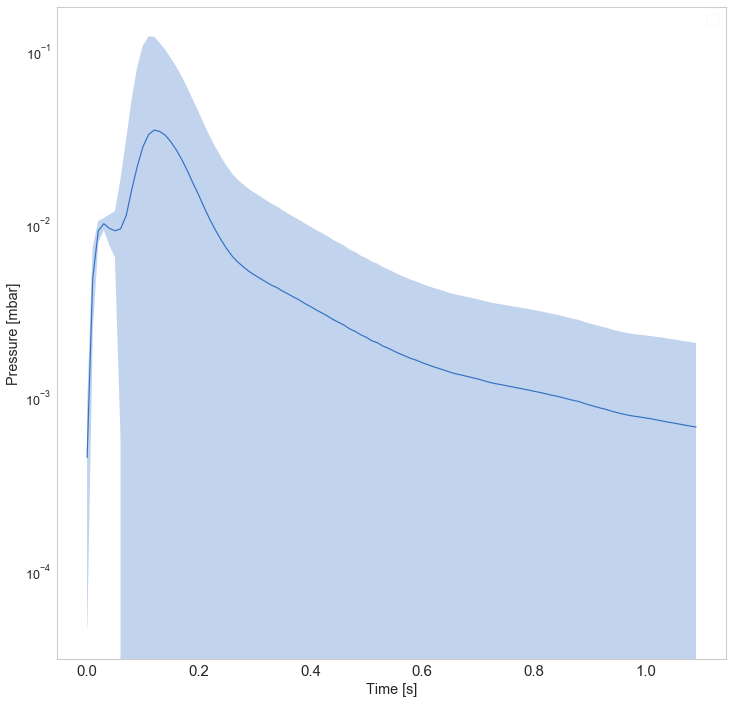

In [220]:
plotAverageProfile(dfp_acn)

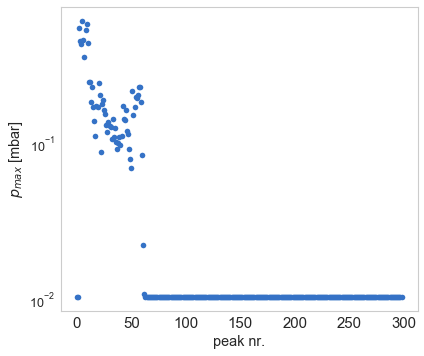

In [221]:
plot_maxP(dfp_acn, ax=plt.gca());

# Other: thumbnail matrix

In [ ]:
findRecoveryPoints()

In [107]:
Ncol = int(np.floor(np.sqrt(Npeaks)))
Nrow = Ncol + 1
Nrow, Ncol, Npeaks

(18, 17, 304)

In [ ]:
fig, ax = plt.subplots(Nrow, Ncol, figsize=(20,20))
for n,p in enumerate(dfp):
    i = n//Ncol
    j = n % Ncol
    print(i, 
#     plt.semilogy(x, dfp[p])

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
5 15
5 16
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
6 15
6 16
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
7 15
7 16
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
8 15
8 16
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
9 15
9 16
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
10 15
10 16
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
11 15
11 16
12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 1

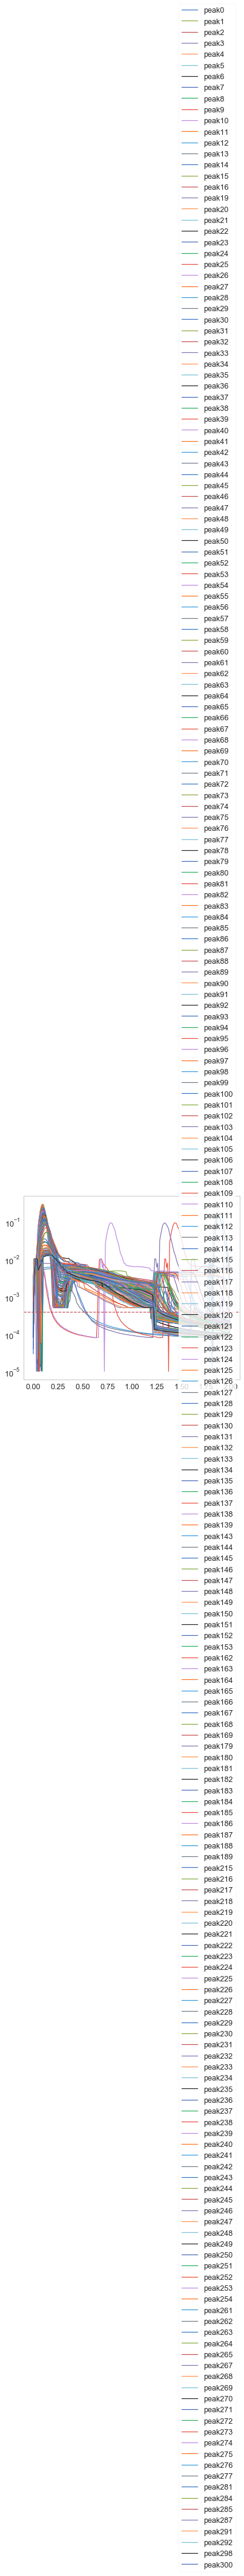

In [79]:
for p in wetPeaks:
    plt.semilogy(x, wetPeaks[p], label=p)
    plt.legend(loc='right')
plt.axhline(4e-4, c='r', ls='--', label='$p_{thres}$ for $t_{rec}$ analysis')

In [42]:
files[0]

'../../ali_data/ALBA/20200310_FBI_NiBr2_400mbar_10ms'